# Kaggle: AI Driven Biomedical Hackathon - Classification Of Omics Experiments Using Natural Language Processing (NLP)

## Table of Contents:
1. [Introduction](#1)    
    1.1 [Overview of Problem](#1.1)    
    1.2 [Unique Challenge & Our Approach](#1.2)
2. [Data Exploration](#2)    
    2.1 [Identifiying Relevant Columns](#2)    
    2.2 [Text Cleaning & Exploration](#2.2)
3. [Feature Extraction](#3)    
    3.1 [Term Frequency – Inverse Document Frequency](#3)    
    3.2 [Identifying Key Word Relating to Controls (Adding Domain Knowledge)](#3.2)
4. [Validation Strategy](#4)
5. [Models Training & Testing](#5)    
    5.1 [Baseline Model](#5)    
    5.2 [Domain Knowledege Model](#5.2)    
    5.3 [Semi-supervised Learning (Pseudo-labelling)](#5.3)
6. [Summary Of All Models' Performances](#6)
7. [Future Work](#7)
8. [Conclusion](#8)


# 1. Introduction  <a name="1"></a>
## 1.1 Overview of Problem <a name="1.1"></a>
<p align = 'justify'> The dataset from the MLRW 2022: AI Driven Biomedical Hackathon (<a href = 'https://www.kaggle.com/competitions/mlrw-biomedicalhackathon'>https://www.kaggle.com/competitions/mlrw-biomedicalhackathon</a>) is a collection of tabular records of experiments obtained from omics repositories such as the Gene Expression Omnibus (GEO). The objective is to train a machine learning model to classify these experiments into control or perturbation (non-controls). In doing so, this will help in the efforts to automate the data mining of such omics repository which will aid in the discovery of biological causes of diseases and novel drugs. <p>




## 1.2 Unique Challenge & Our Approach  <a name="1.2"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
import numpy as np
import time
import scipy # import skippy peanut butter

In [ ]:
path = '/content/drive/MyDrive/BS6201 Project/'
train_labelled_df = pd.read_csv(path + 'labelled_train_data.csv')
train_unlabelled_df = pd.read_csv(path + 'unlabelled_train_data.csv')
test_df = pd.read_csv(path +'data_only_test.csv')

print(f'Labelled train data: {train_labelled_df.shape[0]} rows')
print(f'Unlabelled train data: {train_unlabelled_df.shape[0]} rows')
print(f'Total train data: {train_labelled_df.shape[0] + train_unlabelled_df.shape[0]} rows')
print(f'Test data: {test_df.shape[0]} rows')

Labelled train data: 623 rows
Unlabelled train data: 19456 rows
Total train data: 20079 rows
Test data: 6070 rows


## Challenge:
<p align = 'justify'> The number of labelled samples in the training dataset is only <font size = '4'> <u>623</u> </font> out of 20,079 samples. The number of unlabelled samples is <font size = '4'> <u>19,456</u> </font> and the number of test samples is <font size = '4'> <u>6,070</u> </font>. This presents a unique challenge to train a good model with the limited number of labelled data.</p>

## Approach:
<p align = 'justify'> <font size = '4'> <u>Data centric approach</u> </font> - The focus will be less on complex models and/or model parameters tuning (model-centric approach) and instead focus on improving the quality of the data. This will be done through careful data and feature selection, and <font size = 
'4'> <b> domain knowledge-based </b> <font> feature engineering.</p>

<p align = 'justify'> <font size = '4'> <u>Semi-supervised learning</u> </font> - In order to tackle the low amount of labelled data, a semi-supervised learning technique known as <font size = 4><b>pseudo-labelling</b></font> will be used. This technique includes training on the small labelled dataset and taking high confidence prediction on the unlabelled training set as pseudo labels. The classification model wil then be retrained with both labels and pseudo labels.</p>

# 2. Data Exploration <a name="2"></a>
## 2.1 Identifying Relevant Columns
Check number of columns/features

In [ ]:
print(f'Labelled train data: {train_labelled_df.shape[1]} rows')
print(f'Unlabelled train data: {train_unlabelled_df.shape[1]} rows')
print(f'Test data: {test_df.shape[1]} columns')

Labelled train data: 53 rows
Unlabelled train data: 51 rows
Test data: 51 columns


Check which are the 2 extra columns in the labelled dataframe.

In [ ]:
print(train_labelled_df.columns[~(train_labelled_df.columns.isin(train_unlabelled_df.columns))])
print(train_labelled_df.columns[~(train_labelled_df.columns.isin(test_df.columns))])

Index(['ctrl', 'pert'], dtype='object')
Index(['ctrl', 'pert'], dtype='object')


Columns 'ctrl', and 'pert' are the labels, and are opposite of one another (i.e. when ctrl = 0, pert = 1 and vice versa)

In [ ]:
train_labelled_df.head()

,Unnamed: 0,geo_accession,gse_id,ctrl,pert,channel_count,characteristics_ch1,contact_address,contact_city,contact_country,...,extract_protocol_ch2,label_ch2,label_protocol_ch2,molecule_ch2,organism_ch2,source_name_ch2,taxid_ch2,treatment_protocol_ch2,biomaterial_provider_ch2,growth_protocol_ch2
0,0,GSM1617977,GSE66250,0,1,1,facs sorting: CD44low/CD24high,Am Hubland,Wuerzburg,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GSM1617983,GSE66250,0,1,1,facs sorting: Unsorted,Am Hubland,Wuerzburg,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,GSM1617982,GSE66250,1,0,1,facs sorting: CD44low/CD24high,Am Hubland,Wuerzburg,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,GSM1617975,GSE66250,0,1,1,facs sorting: CD44high/CD24low,Am Hubland,Wuerzburg,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,GSM1267968,GSE52505,0,1,1,tissue: human nasal polyp,"148, Gurodong-ro, Guro-gu",Seoul,South Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_labelled_df.columns.values

array(['Unnamed: 0', 'geo_accession', 'gse_id', 'ctrl', 'pert',
       'channel_count', 'characteristics_ch1', 'contact_address',
       'contact_city', 'contact_country', 'contact_department',
       'contact_email', 'contact_institute', 'contact_name',
       'contact_state', 'data_processing', 'data_row_count',
       'description', 'extract_protocol_ch1', 'growth_protocol_ch1',
       'hyb_protocol', 'label_ch1', 'label_protocol_ch1',
       'last_update_date', 'molecule_ch1', 'organism_ch1', 'platform_id',
       'scan_protocol', 'source_name_ch1', 'status', 'submission_date',
       'supplementary_file', 'taxid_ch1', 'title',
       'treatment_protocol_ch1', 'type', 'contact_phone',
       'contact_laboratory', 'relation', 'contact_fax',
       'biomaterial_provider_ch1', 'contact_web_link',
       'characteristics_ch2', 'extract_protocol_ch2', 'label_ch2',
       'label_protocol_ch2', 'molecule_ch2', 'organism_ch2',
       'source_name_ch2', 'taxid_ch2', 'treatment_protocol_ch2'

Check missing values and rectify

In [ ]:
train_labelled_df.isnull().sum()

Unnamed: 0                    0
geo_accession                 0
gse_id                        0
ctrl                          0
pert                          0
channel_count                 0
characteristics_ch1           0
contact_address               0
contact_city                  0
contact_country               0
contact_department          120
contact_email               229
contact_institute             0
contact_name                  0
contact_state               174
data_processing               0
data_row_count                0
description                 147
extract_protocol_ch1          0
growth_protocol_ch1         341
hyb_protocol                110
label_ch1                   110
label_protocol_ch1          110
last_update_date              0
molecule_ch1                  0
organism_ch1                  0
platform_id                   0
scan_protocol               110
source_name_ch1               0
status                        0
submission_date               0
suppleme

<p align = 'justify'>The number of missing values in some of these columns range from 110 - 619. 

This is about 17.6 - 99.36% of the total samples. 

As the number of labelled data is already low and these columns have high percentage of missing values, we will drop these columns.</p>

In [ ]:
train_labelled_df = train_labelled_df.dropna(axis = 1, thresh = 200)
common_cols = list(set(train_labelled_df.columns).intersection(train_unlabelled_df.columns))
train_unlabelled_df = train_unlabelled_df[common_cols]
test_df =  test_df[common_cols]

In [ ]:
train_labelled_df.columns.values

array(['Unnamed: 0', 'geo_accession', 'gse_id', 'ctrl', 'pert',
       'channel_count', 'characteristics_ch1', 'contact_address',
       'contact_city', 'contact_country', 'contact_department',
       'contact_email', 'contact_institute', 'contact_name',
       'contact_state', 'data_processing', 'data_row_count',
       'description', 'extract_protocol_ch1', 'growth_protocol_ch1',
       'hyb_protocol', 'label_ch1', 'label_protocol_ch1',
       'last_update_date', 'molecule_ch1', 'organism_ch1', 'platform_id',
       'scan_protocol', 'source_name_ch1', 'status', 'submission_date',
       'supplementary_file', 'taxid_ch1', 'title',
       'treatment_protocol_ch1', 'type', 'contact_laboratory'],
      dtype=object)

In [ ]:
train_labelled_df[['Unnamed: 0', 'geo_accession', 'gse_id', 'channel_count', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'data_row_count', 'last_update_date', 'platform_id', 'submission_date', 'status', 'type', 'molecule_ch1', 'organism_ch1', 'taxid_ch1', 'data_processing', 'extract_protocol_ch1', 'contact_email',	'contact_state', 'contact_department', 'growth_protocol_ch1', 'hyb_protocol',	'label_ch1',	'label_protocol_ch1', 'scan_protocol',	'supplementary_file', 'contact_laboratory', 'treatment_protocol_ch1']]

,Unnamed: 0,geo_accession,gse_id,channel_count,contact_address,contact_city,contact_country,contact_institute,contact_name,data_row_count,...,contact_state,contact_department,growth_protocol_ch1,hyb_protocol,label_ch1,label_protocol_ch1,scan_protocol,supplementary_file,contact_laboratory,treatment_protocol_ch1
0,0,GSM1617977,GSE66250,1,Am Hubland,Wuerzburg,Germany,University of Wuerzburg,"Martin,,Eilers",0,...,NaN,Chair for Biochemistry and Molecular Biology,IMEC cell lines were grown in DMEM/F-12 with a...,NaN,NaN,NaN,NaN,NaN,Martin Eilers,Cell were infected with the indicated doxycycl...
1,1,GSM1617983,GSE66250,1,Am Hubland,Wuerzburg,Germany,University of Wuerzburg,"Martin,,Eilers",0,...,NaN,Chair for Biochemistry and Molecular Biology,IMEC cell lines were grown in DMEM/F-12 with a...,NaN,NaN,NaN,NaN,NaN,Martin Eilers,Cell were infected with the indicated doxycycl...
2,2,GSM1617982,GSE66250,1,Am Hubland,Wuerzburg,Germany,University of Wuerzburg,"Martin,,Eilers",0,...,NaN,Chair for Biochemistry and Molecular Biology,IMEC cell lines were grown in DMEM/F-12 with a...,NaN,NaN,NaN,NaN,NaN,Martin Eilers,Cell were infected with the indicated doxycycl...
3,3,GSM1617975,GSE66250,1,Am Hubland,Wuerzburg,Germany,University of Wuerzburg,"Martin,,Eilers",0,...,NaN,Chair for Biochemistry and Molecular Biology,IMEC cell lines were grown in DMEM/F-12 with a...,NaN,NaN,NaN,NaN,NaN,Martin Eilers,Cell were infected with the indicated doxycycl...
4,0,GSM1267968,GSE52505,1,"148, Gurodong-ro, Guro-gu",Seoul,South Korea,Korea universitiy guro hospital,"Heung-Man,,Lee",34127,...,NaN,Department of otorhinolaryngology,Nasal fibroblasts were isolated from surgical ...,"After checking labeling efficiency, fragmentat...",Cy3,Amplified and labeled cRNA was purified on cRN...,The hybridized images were scanned using Agile...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1267...,ENT,Freshly drawn nasal fibroblasts were treated w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0,GSM1462977,GSE59980,1,1450 Biggy Street NRT6514,Los Angeles,USA,USC,"Matt,,Grimmer",0,...,CA,Biochemistry,Thawing Cells: 1. Thaw vial immediately in 37...,NaN,NaN,NaN,NaN,NaN,Peggy Farnham,ATF plasmids were designed and stably integrat...
619,1,GSM1462972,GSE59980,1,1450 Biggy Street NRT6514,Los Angeles,USA,USC,"Matt,,Grimmer",0,...,CA,Biochemistry,Thawing Cells: 1. Thaw vial immediately in 37...,NaN,NaN,NaN,NaN,NaN,Peggy Farnham,ATF plasmids were designed and stably integrat...
620,2,GSM1462974,GSE59980,1,1450 Biggy Street NRT6514,Los Angeles,USA,USC,"Matt,,Grimmer",0,...,CA,Biochemistry,Thawing Cells: 1. Thaw vial immediately in 37...,NaN,NaN,NaN,NaN,NaN,Peggy Farnham,ATF plasmids were designed and stably integrat...
621,3,GSM1462976,GSE59980,1,1450 Biggy Street NRT6514,Los Angeles,USA,USC,"Matt,,Grimmer",0,...,CA,Biochemistry,Thawing Cells: 1. Thaw vial immediately in 37...,NaN,NaN,NaN,NaN,NaN,Peggy Farnham,ATF plasmids were designed and stably integrat...


<p align = 'justify'> The columns ['Unnamed: 0', 'geo_accession', 'gse_id', 'channel_count', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'data_row_count', 'last_update_date', 'platform_id', 'submission_date', 'status', 'type', 'molecule_ch1', 'organism_ch1', 'taxid_ch1', 'data_processing'] are generic to each overall experiment and do not affect the dependent 'ctrl' variable and can be dropped. </p>

In [ ]:
#@title
train_labelled_df = train_labelled_df.drop(['Unnamed: 0', 'geo_accession', 'gse_id', 'channel_count', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'data_row_count', 'last_update_date', 'platform_id', 'submission_date', 'status', 'type', 'molecule_ch1', 'organism_ch1', 'taxid_ch1', 'data_processing', 'extract_protocol_ch1', 'contact_email',	'contact_state', 'contact_department', 'growth_protocol_ch1', 'hyb_protocol',	'label_ch1',	'label_protocol_ch1', 'scan_protocol',	'supplementary_file', 'contact_laboratory', 'treatment_protocol_ch1'], axis=1)
train_unlabelled_df = train_unlabelled_df.drop(['Unnamed: 0', 'geo_accession', 'gse_id', 'channel_count', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'data_row_count', 'last_update_date', 'platform_id', 'submission_date', 'status', 'type', 'molecule_ch1', 'organism_ch1', 'taxid_ch1', 'data_processing', 'extract_protocol_ch1', 'contact_email',	'contact_state', 'contact_department', 'growth_protocol_ch1', 'hyb_protocol',	'label_ch1',	'label_protocol_ch1', 'scan_protocol',	'supplementary_file', 'contact_laboratory', 'treatment_protocol_ch1'], axis=1)
test_df = test_df.drop(['Unnamed: 0', 'geo_accession', 'gse_id', 'channel_count', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'data_row_count', 'last_update_date', 'platform_id', 'submission_date', 'status', 'type', 'molecule_ch1', 'organism_ch1', 'taxid_ch1', 'data_processing', 'extract_protocol_ch1', 'contact_email',	'contact_state', 'contact_department', 'growth_protocol_ch1', 'hyb_protocol',	'label_ch1',	'label_protocol_ch1', 'scan_protocol',	'supplementary_file', 'contact_laboratory', 'treatment_protocol_ch1'], axis=1)

train_labelled_df = train_labelled_df.drop('pert', axis = 1)
train_labelled_df

,ctrl,characteristics_ch1,description,source_name_ch1,title
0,0,facs sorting: CD44low/CD24high,cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_...,Sorted HMLE cell line,rep1_cd44low_dox
1,0,facs sorting: Unsorted,imecs_myc_dox_vs_vector_dox.txt,IMEC cell line,rep1_imecs_myc_dox
2,1,facs sorting: CD44low/CD24high,cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_...,Sorted HMLE cell line,rep2_cd44low_etoh
3,0,facs sorting: CD44high/CD24low,cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_...,Sorted HMLE cell line,rep1_cd44high_dox
4,0,tissue: human nasal polyp,Gene expression of LPS-stimulated nasal fibrob...,nasal polyp,lipopolysaccharide treated sample replication 2
...,...,...,...,...,...
618,0,cell line: MCF7,RNA-seq_598-SKD.txt,Human breast adenocarcinoma cell-line MCF7,RNA-seq_598-SKD_3dDox_rep3
619,1,cell line: MCF7,RNA-seq_598-SKD.txt,Human breast adenocarcinoma cell-line MCF7,RNA-seq_598-SKD_0dDox_rep1
620,1,cell line: MCF7,RNA-seq_598-SKD.txt,Human breast adenocarcinoma cell-line MCF7,RNA-seq_598-SKD_0dDox_rep3
621,0,cell line: MCF7,RNA-seq_598-SKD.txt,Human breast adenocarcinoma cell-line MCF7,RNA-seq_598-SKD_3dDox_rep2


<p align = 'justify'> The remaining feature columns 'characteristics_ch1', 'description', 'source_name_ch1' and 'title' contains free text data that corresponds to the dependant variable 'ctrl'. The particular keywords that indicate control/non-control can be found in the text of any of these 4 feature columns. <p>

## 2.2 Text Cleaning & Exploration <a name="2.2"></a>
A few observations of the text:
* Keywords that identify controls may appear in any of the 4 identified columns.
* The content of each of these 4 columns can be simlar and no proper unified way of differentiating them.
* Text contains many unwanted punctuation marks such as '_', '.', ':', '-', '/'.
* Text contains numbers.
* Text contain many biological related terms.


Check for missing text

In [ ]:
train_labelled_df.isnull().sum()

ctrl                     0
characteristics_ch1      0
description            147
source_name_ch1          0
title                    0
dtype: int64

Replace missing text with blank string

In [ ]:
train_labelled_df = train_labelled_df.fillna('')
train_unlabelled_df = train_unlabelled_df.fillna('')
test_df = test_df.fillna('')

Combine the 4 text columns into a single text feature

In [ ]:
train_labelled_df['combined_text'] = train_labelled_df['characteristics_ch1'] + ' ' + train_labelled_df['description'] + ' ' + train_labelled_df['source_name_ch1'] + ' ' + train_labelled_df['title']
train_unlabelled_df['combined_text'] = train_unlabelled_df['characteristics_ch1'] + ' ' + train_unlabelled_df['description'] + ' ' + train_unlabelled_df['source_name_ch1'] + ' ' + train_unlabelled_df['title']
test_df['combined_text'] = test_df['characteristics_ch1'] + ' ' + test_df['description'] + ' ' + test_df['source_name_ch1'] + ' ' + test_df['title']
train_labelled_df['combined_text'].unique()[0:10]

array(['facs sorting: CD44low/CD24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt Sorted HMLE cell line rep1_cd44low_dox',
       'facs sorting: Unsorted imecs_myc_dox_vs_vector_dox.txt IMEC cell line rep1_imecs_myc_dox',
       'facs sorting: CD44low/CD24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt Sorted HMLE cell line rep2_cd44low_etoh',
       'facs sorting: CD44high/CD24low cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt Sorted HMLE cell line rep1_cd44high_dox',
       'tissue: human nasal polyp Gene expression of LPS-stimulated nasal fibroblasts for 12hr nasal polyp lipopolysaccharide treated sample replication 2',
       'tissue: human nasal polyp Gene expression of untreated-nasal fibroblasts nasal polyp untreated control replication 1',
       'tissue: human nasal polyp Gene expression of untreated-nasal fibroblasts nasal polyp untreated control replication 2',
       'tissue: human nasal polyp Gene expression of LPS-st

Set text to lowercase

In [ ]:
train_labelled_df['combined_text'] = train_labelled_df['combined_text'].apply(lambda x: x.lower())
train_unlabelled_df['combined_text'] = train_unlabelled_df['combined_text'].apply(lambda x: x.lower())
test_df['combined_text'] = test_df['combined_text'].apply(lambda x: x.lower())

train_labelled_df['combined_text'].unique()[0:10]

array(['facs sorting: cd44low/cd24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep1_cd44low_dox',
       'facs sorting: unsorted imecs_myc_dox_vs_vector_dox.txt imec cell line rep1_imecs_myc_dox',
       'facs sorting: cd44low/cd24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep2_cd44low_etoh',
       'facs sorting: cd44high/cd24low cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep1_cd44high_dox',
       'tissue: human nasal polyp gene expression of lps-stimulated nasal fibroblasts for 12hr nasal polyp lipopolysaccharide treated sample replication 2',
       'tissue: human nasal polyp gene expression of untreated-nasal fibroblasts nasal polyp untreated control replication 1',
       'tissue: human nasal polyp gene expression of untreated-nasal fibroblasts nasal polyp untreated control replication 2',
       'tissue: human nasal polyp gene expression of lps-st

Replace punctuation marks and numbers with blank string.

In [ ]:
train_labelled_df['combined_text_clean'] = train_labelled_df['combined_text'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
train_labelled_df['combined_text_clean'] = train_labelled_df['combined_text_clean'].apply(lambda x: re.sub('\d', '', x))
train_labelled_df['combined_text_clean'] = train_labelled_df['combined_text_clean'].replace(r'\s+', ' ', regex=True)

train_unlabelled_df['combined_text_clean'] = train_unlabelled_df['combined_text'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
train_unlabelled_df['combined_text_clean'] = train_unlabelled_df['combined_text_clean'].apply(lambda x: re.sub('\d', '', x))
train_unlabelled_df['combined_text_clean'] = train_unlabelled_df['combined_text_clean'].replace(r'\s+', ' ', regex=True)

test_df['combined_text_clean'] = test_df['combined_text'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
test_df['combined_text_clean'] = test_df['combined_text_clean'].apply(lambda x: re.sub('\d', '', x))
test_df['combined_text_clean'] = test_df['combined_text_clean'].str.strip()

train_labelled_df['combined_text_clean'].unique()[0:10]

array(['facs sorting cdlow cdhigh cdhigh dox vs etoh txt and cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdlow dox',
       'facs sorting unsorted imecs myc dox vs vector dox txt imec cell line rep imecs myc dox',
       'facs sorting cdlow cdhigh cdhigh dox vs etoh txt and cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdlow etoh',
       'facs sorting cdhigh cdlow cdhigh dox vs etoh txt and cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdhigh dox',
       'tissue human nasal polyp gene expression of lps stimulated nasal fibroblasts for hr nasal polyp lipopolysaccharide treated sample replication ',
       'tissue human nasal polyp gene expression of untreated nasal fibroblasts nasal polyp untreated control replication ',
       'infection mutant dlnta listeria lovo cells infected with mutant dlnta listeria biological rep lovo cells infected with mutant dlnta listeria biological rep',
       'infection lnta v+ listeria lovo cells infected with lnta v+ li

Remove stop words and lemmatize

In [ ]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
train_labelled_df['lemmatized'] = train_labelled_df['combined_text_clean'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
train_labelled_df['lemmatized'].unique()[0:10]

array(['facs sort cdlow cdhigh cdhigh dox vs etoh txt cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdlow dox',
       'facs sort unsorted imecs myc dox vs vector dox txt imec cell line rep imecs myc dox',
       'facs sort cdlow cdhigh cdhigh dox vs etoh txt cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdlow etoh',
       'facs sort cdhigh cdlow cdhigh dox vs etoh txt cdhigh etoh vs cdlow etoh txt sorted hmle cell line rep cdhigh dox',
       'tissue human nasal polyp gene expression lps stimulate nasal fibroblast hr nasal polyp lipopolysaccharide treat sample replication',
       'tissue human nasal polyp gene expression untreated nasal fibroblast nasal polyp untreated control replication',
       'infection mutant dlnta listeria lovo cell infect mutant dlnta listeria biological rep lovo cell infect mutant dlnta listeria biological rep',
       'infection lnta v+ listeria lovo cell infect lnta v+ listeria biological rep lovo cell infect lnta v+ listeria biologica

Document Term Matrix

In [ ]:
train_labelled_df_grouped = train_labelled_df[['ctrl', 'lemmatized']].groupby(by = 'ctrl').agg(lambda x:' '. join(x))
cv = CountVectorizer(analyzer = 'word')
data = cv.fit_transform(train_labelled_df_grouped['lemmatized'])
dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names())
dtm.index = train_labelled_df_grouped.index
dtm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aav,ab,acid,acta,activate,ad,additional,adenocarcinoma,adenoviral,adipose,...,wthdr,xe,yap,yf,yfp,yolk,zinc,znd,δescv,δiec
ctrl,,,,,,,,,,,,,,,,,,,,,
0,2,26,1,4,4,0,4,7,2,2,...,1,0,6,2,5,1,3,3,4,0
1,3,1,0,3,0,10,0,14,2,2,...,0,3,0,0,0,0,0,0,0,1


Word Cloud

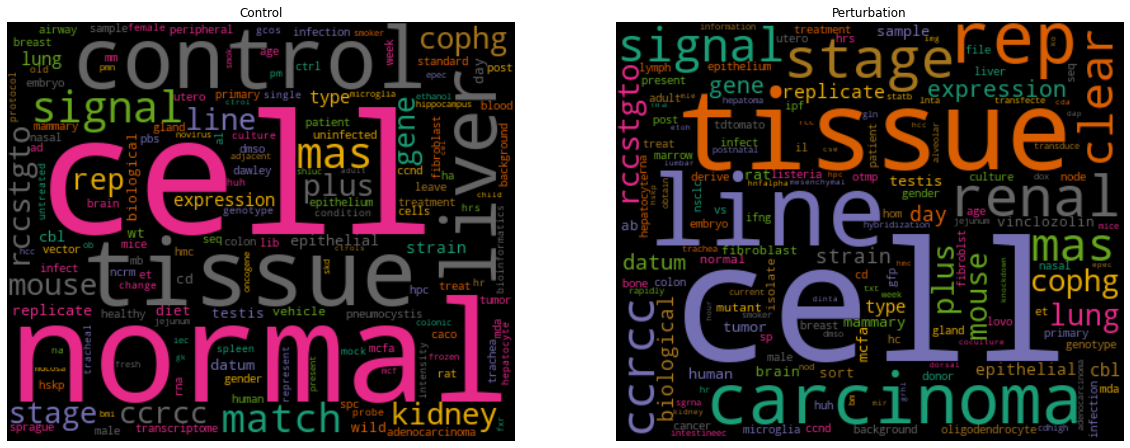

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

wc_control = WordCloud(width = 400, height = 330, max_words = 150, colormap = 'Dark2').generate_from_frequencies(dtm.iloc[1])
wc_pert = WordCloud(width = 400, height = 330, max_words = 150, colormap = 'Dark2').generate_from_frequencies(dtm.iloc[0])

ax[0].imshow(wc_control, interpolation = 'bilinear')
ax[0].axis('off')
ax[0].set_title('Control')

ax[1].imshow(wc_pert, interpolation = 'bilinear')
ax[1].axis('off')
ax[1].set_title('Perturbation')

plt.show()

* Overlap of words in both groups such as cell, tissue etc.
* Words that appear multiple times in "control group" are "control" and "normal".
* There is also some short forms of the word control such as 'ctrl' and its variance.

# 3. Feature Extraction <a name="3"></a>
## 3.1 Term Frequency - Inverse Document Frequency
<p align = 'justify'> For each word in the document, the TF-IDF is a measure of the word's importance in the corpus. It has a higher value when the word appear less frequently overall in all documents but appears frequently in a single document. </p>

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_train_labelled = vectorizer.fit_transform(train_labelled_df['combined_text_clean'])
tfidf_train_unlabelled = vectorizer.transform(train_unlabelled_df['combined_text_clean'])
tfidf_test = vectorizer.transform(test_df['combined_text_clean'])
tfidf_train_labelled.shape

(623, 728)

## 3.2 Identifying Key Words Relating to Controls (Adding Domain knowledge) <a name="3.2"></a>
<p align = 'justify'> In different biomedical experiments, there are many different ways in which researchers label their control experiments. This can go from the standard "control" to abbreviations, to those that require domain knowledge to identify such as 'wild type', 'naive' and 'placebo'. Some researchers also label their controls with the name of the buffer solution to indicate no treatment such as 'etoh' and 'dox'. For this section, I will try to incorporate these biomedical domain knowledge to improve the model. </p>

Create list of control abbreviations and list of domain related control naming 
keywords.

In [ ]:
# abbr = ['ctrl', 'ctrol', 'ctl', 'cntrl', 'ctr', 'cont', 'con']
# dom_rel = ['wild', 'wildtype', 'wt', 'mock', 'vehicle', 'uninfected', 'untreated', 'dmso', 'saline', 'naive', 'naïve', 'placebo', 'healthy', 'normal', 'pbs', 'veh', 'untouched', 'nonsmoker', 'dox', 'etoh']
# vocab = abbr + dom_rel
vocab_lis = ['control', 'ctrl', 'wild', 'wild type', 'wild-type', 'wt', 'mock', 'vehicle', 'never', 'uninfected']
addition = ['ctrol', 'ctl', 'cntrl', '_normal', 'untreated', '_con', '_con_', 'con_', 'dmso', 'saline',  'wildtype', 'naive', 'naïve', 'placebo', 'healthy', 'normal', '.con.', '.con', 'con.', '_before', 'before ', 'pbs', '+/-', '+/+', '_ctr', 'ctr_', '_ctr', 'ctr ', ' ctr', ' ctr ', 'con_', '_con_', '_con', 'con ', ' con', ' con ', 'ct ', ' ct', ' ct ', '_ct', 'ct_', '_ct_', 'veh ', ' veh', ' veh ', '_veh', 'veh_', '_veh_', 'cont ', ' cont', ' cont ', '_cont', 'cont_', '_cont_', 'no_dox', 'no dox', 'etoh', 'untouched', 'non-tumor', 'nonsmoker', 'non-smoker', 'non-cancerous', 'no treated']
vocab = vocab_lis + addition

Replace keywords with "control".

In [ ]:
train_labelled_df['combined_text_dk'] = train_labelled_df['combined_text'] + ' ' + [' '.join('control' for y in x.split() if any(word in y for word in vocab)) for x in train_labelled_df['combined_text']]
train_unlabelled_df['combined_text_dk'] = train_unlabelled_df['combined_text'] + ' ' + [' '.join('control' for y in x.split() if any(word in y for word in vocab)) for x in train_unlabelled_df['combined_text']]
test_df['combined_text_dk'] = test_df['combined_text'] + ' ' + [' '.join('control' for y in x.split() if any(word in y for word in vocab)) for x in test_df['combined_text']]

train_labelled_df['combined_text_dk'].unique()[0:10]

array(['facs sorting: cd44low/cd24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep1_cd44low_dox control control',
       'facs sorting: unsorted imecs_myc_dox_vs_vector_dox.txt imec cell line rep1_imecs_myc_dox ',
       'facs sorting: cd44low/cd24high cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep2_cd44low_etoh control control control',
       'facs sorting: cd44high/cd24low cd44high_dox_vs_etoh.txt and cd44high_etoh_vs_cd44low_etoh.txt sorted hmle cell line rep1_cd44high_dox control control',
       'tissue: human nasal polyp gene expression of lps-stimulated nasal fibroblasts for 12hr nasal polyp lipopolysaccharide treated sample replication 2 ',
       'tissue: human nasal polyp gene expression of untreated-nasal fibroblasts nasal polyp untreated control replication 1 control control control',
       'tissue: human nasal polyp gene expression of untreated-nasal fibroblasts nasal polyp untreated c

Remove punctuation marks.

In [ ]:
train_labelled_df['combined_text_dk_clean'] = train_labelled_df['combined_text_dk'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
train_labelled_df['combined_text_dk_clean'] = train_labelled_df['combined_text_dk_clean'].apply(lambda x: re.sub('\d', '', x))
train_labelled_df['combined_text_dk_clean'] = train_labelled_df['combined_text_dk_clean'].replace(r'\s+', ' ', regex=True)

train_unlabelled_df['combined_text_dk_clean'] = train_unlabelled_df['combined_text_dk'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
train_unlabelled_df['combined_text_dk_clean'] = train_unlabelled_df['combined_text_dk_clean'].apply(lambda x: re.sub('\d', '', x))
train_unlabelled_df['combined_text_dk_clean'] = train_unlabelled_df['combined_text_dk_clean'].replace(r'\s+', ' ', regex=True)

test_df['combined_text_dk_clean'] = test_df['combined_text_dk'].apply(lambda x: x.replace('_', ' ').replace('/', ' ').replace('.', ' ').replace(':', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ').replace("'", ' ').replace(',', ' ').replace('#', ' '))
test_df['combined_text_dk_clean'] = test_df['combined_text_dk_clean'].apply(lambda x: re.sub('\d', '', x))
test_df['combined_text_dk_clean'] = test_df['combined_text_dk_clean'].str.strip()


Check Word Cloud

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


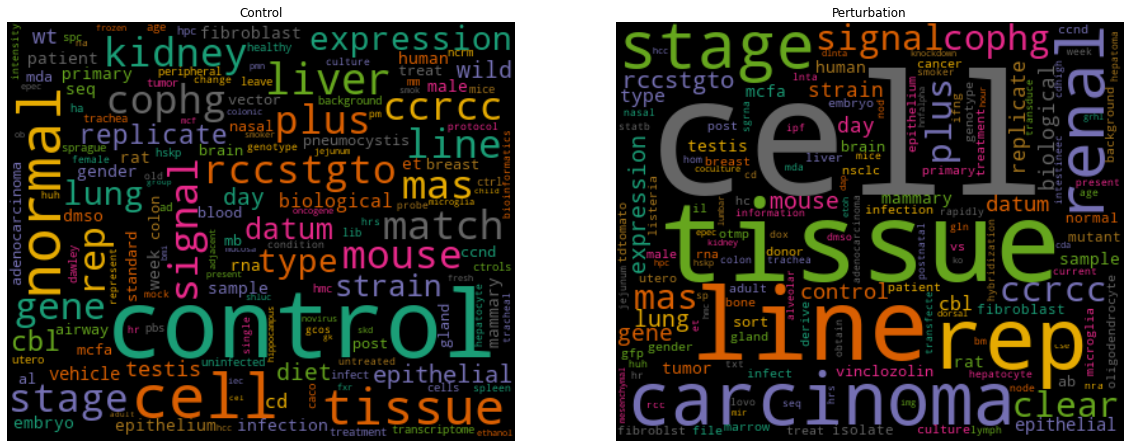

In [ ]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
train_labelled_df['lemmatized_dk'] = train_labelled_df['combined_text_dk_clean'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

train_labelled_df_grouped = train_labelled_df[['ctrl', 'lemmatized_dk']].groupby(by = 'ctrl').agg(lambda x:' '. join(x))
cv = CountVectorizer(analyzer = 'word')
data = cv.fit_transform(train_labelled_df_grouped['lemmatized_dk'])
dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names())
dtm.index = train_labelled_df_grouped.index

fig, ax = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

wc_control = WordCloud(width = 400, height = 330, max_words = 150, colormap = 'Dark2').generate_from_frequencies(dtm.iloc[1])
wc_pert = WordCloud(width = 400, height = 330, max_words = 150, colormap = 'Dark2').generate_from_frequencies(dtm.iloc[0])

ax[0].imshow(wc_control, interpolation = 'bilinear')
ax[0].axis('off')
ax[0].set_title('Control')

ax[1].imshow(wc_pert, interpolation = 'bilinear')
ax[1].axis('off')
ax[1].set_title('Perturbation')

plt.show()

Create TF-IDF features

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_train_labelled_dk = vectorizer.fit_transform(train_labelled_df['combined_text_dk_clean'])
tfidf_train_unlabelled_dk = vectorizer.transform(train_unlabelled_df['combined_text_dk_clean'])
tfidf_test_dk = vectorizer.transform(test_df['combined_text_dk_clean'])
tfidf_train_labelled_dk.shape

(623, 728)

# 4. Validation Strategy <a name="4"></a>
<p align = 'justify'> The training dataset will be split into a 80-20 train and validation set. The model will be trained on the train set and fined tuned using the validation set. The finalized models will then be tested on the test set by submitting the results to the competition assessment <a href = 'https://www.kaggle.com/competitions/mlrw-biomedicalhackathon/submit'>submission page</a> on Kaggle. <p>

In [ ]:
train_labelled_df['ctrl'].value_counts()

0    319
1    304
Name: ctrl, dtype: int64

The labels are quite balanced, we can choose to use or not use stratification when splitting.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(tfidf_train_labelled, train_labelled_df['ctrl'], test_size = 0.2, random_state = 420)
x_train_dk, x_val_dk, y_train_dk, y_val_dk = train_test_split(tfidf_train_labelled_dk, train_labelled_df['ctrl'], test_size = 0.2, random_state = 420)

# 5. Models Training & Testing <a name="5"></a>
## 5.1 Baseline Model
Train model with just simple TF-IDF features.

In [ ]:
clf_baseline = RandomForestClassifier()
clf_baseline.fit(x_train, y_train)
pred = clf_baseline.predict(x_val)
pred_proba = clf_baseline.predict_proba(x_val)

Evaluation results

In [ ]:
print(f'F1 Score (competition metric): {f1_score(y_val, pred)}')
print(f'Accuracy: {accuracy_score(y_val, pred)}')
print(f'AUC Score: {roc_auc_score(y_val, pred_proba[:, 1])}')
print(f'Confusion Matrix: \n{confusion_matrix(y_val, pred)}')

F1 Score (competition metric): 0.8983050847457625
Accuracy: 0.904
AUC Score: 0.9742571721311475
Confusion Matrix: 
[[60  4]
 [ 8 53]]


Submit to Kaggle to get test results


In [ ]:
geo_acc = pd.read_csv(path +'data_only_test.csv')
submission = pd.DataFrame({'geo_accession': geo_acc['geo_accession'], 'ctrl': clf_baseline.predict(tfidf_test)})
submission['ctrl'] = submission['ctrl'].astype(np.float64)
submission.to_csv('baseline_submission.csv', index = False, header = True, sep = ',')

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (7).json


{'kaggle.json': b'{"username":"wongkwmelvin","key":"963be251fb8ff847fc78aa4f0f7d5466"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit mlrw-biomedicalhackathon -f baseline_submission.csv -m "Baseline submission."

100% 87.7k/87.7k [00:04<00:00, 22.3kB/s]
Successfully submitted to MLRW 2022 : AI Driven Biomedical Hackathon

Wait for 5 sec for submission to be evaluated.

In [ ]:
time.sleep(5)

In [ ]:
submissions_list = !kaggle competitions submissions mlrw-biomedicalhackathon -q -csv
submissions_list[0:3]

['fileName                     date                 description                        status    publicScore  privateScore  ',
 '---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  ',
 'baseline_submission.csv      2022-10-01 09:53:04  Baseline submission.               complete  0.71993      0.72454       ']

## 5.2 Domain Knowledge Model <a name="5.2"></a>
Train model with domain knowledege TF-IDF features.

In [ ]:
clf_dk = RandomForestClassifier()
clf_dk.fit(x_train_dk, y_train_dk)
pred_dk = clf_dk.predict(x_val_dk)
pred_proba_dk = clf_dk.predict_proba(x_val_dk)

Evaluation results

In [ ]:
print(f'F1 Score (competition metric): {f1_score(y_val_dk, pred_dk)}')
print(f'Accuracy: {accuracy_score(y_val_dk, pred_dk)}')
print(f'AUC Score: {roc_auc_score(y_val_dk, pred_proba_dk[:, 1])}')
print(f'Confusion Matrix: \n{confusion_matrix(y_val_dk, pred_dk)}')

F1 Score (competition metric): 0.9256198347107439
Accuracy: 0.928
AUC Score: 0.9869364754098361
Confusion Matrix: 
[[60  4]
 [ 5 56]]


Submit to Kaggle to get test results

In [ ]:
submission_dk = pd.DataFrame({'geo_accession': geo_acc['geo_accession'], 'ctrl': clf_dk.predict(tfidf_test_dk)})
submission_dk['ctrl'] = submission_dk['ctrl'].astype(np.float64)
submission_dk.to_csv('dk_submission.csv', index = False, header = True, sep = ',')

In [ ]:
!kaggle competitions submit mlrw-biomedicalhackathon -f dk_submission.csv -m "Domain knowledge submission."

100% 87.7k/87.7k [00:02<00:00, 30.0kB/s]
Successfully submitted to MLRW 2022 : AI Driven Biomedical Hackathon

Wait for 5 sec for submission to be evaluated.

In [ ]:
time.sleep(5)

In [ ]:
submissions_list_dk = !kaggle competitions submissions mlrw-biomedicalhackathon -q -csv
submissions_list_dk[0:3]

['fileName                     date                 description                        status    publicScore  privateScore  ',
 '---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  ',
 'dk_submission.csv            2022-10-01 09:53:16  Domain knowledge submission.       complete  0.83525      0.83558       ']

## 5.3 Semi-supervised Learning (Pseudo-labellling) <a name="5.3"></a>
<p align = 'justify'> In this section, we will make use of the model trained on labelled data to make prediction on the unlabelled train data. A threshold probability will be set to ensure that only highly confident predictions will be used as pseudo labels. The pseudo labelled train data will then be concatenated with the actual labelled data and a new model retrained. <!--This will then be repeated until no new pseudo labels can be added. The algorithm is as follows:--> <p>

<!-- 1. Train model on labelled train data (623 rows)
2. Make predictions on unlabelled train data (19456 rows)
3. Set a threshold probability score
4. Add confident predictions (pseudo labels) to the labelled training data
5. Retrain model with psuedo and actual labels
6. Repeat Steps 2 to 6 until no new pseudo labels can be added. -->

Reuse the "baseline" model

In [ ]:
unlabelled_pred_proba = clf_baseline.predict_proba(tfidf_train_unlabelled)
unlabelled_pred_proba.shape

(19456, 2)

Get confident scores of more than 90% probability.

In [ ]:
indices = np.where((unlabelled_pred_proba[:, 0] > 0.95) | (unlabelled_pred_proba[:, 1] > 0.95))
pseudo_labels = unlabelled_pred_proba[np.where((unlabelled_pred_proba[:, 0] > 0.95) | (unlabelled_pred_proba[:, 1] > 0.95)), :].squeeze()
print(pseudo_labels[0:5])
print(pseudo_labels[-5:])
print(pseudo_labels.shape)

[[0.98 0.02]
 [0.98 0.02]
 [0.97 0.03]
 [0.97 0.03]
 [0.97 0.03]]
[[0.96 0.04]
 [0.96 0.04]
 [0.96 0.04]
 [0.96 0.04]
 [0.96 0.04]]
(908, 2)


Convert probabilities to pseudo labels and concatenate to labelled training set.

In [ ]:
pseudo_labels = (pseudo_labels[:, 1] > 0.5).astype(int)
labels_PL = np.hstack([train_labelled_df['ctrl'], pseudo_labels])
tfidf_train_PL = scipy.sparse.vstack([tfidf_train_labelled, tfidf_train_unlabelled[indices]])
print(labels_PL.shape)
print(tfidf_train_PL.shape)

(1531,)
(1531, 728)


Retrain model with actual and pseudo labels.

In [ ]:
clf_PL = RandomForestClassifier()
clf_PL.fit(tfidf_train_PL, labels_PL)

submission_PL = pd.DataFrame({'geo_accession': geo_acc['geo_accession'], 'ctrl': clf_PL.predict(tfidf_test_dk)})
submission_PL['ctrl'] = submission_PL['ctrl'].astype(np.float64)
submission_PL.to_csv('pl_submission.csv', index = False, header = True, sep = ',')

Submit to Kaggle to get test result.

In [ ]:
!kaggle competitions submit mlrw-biomedicalhackathon -f pl_submission.csv -m "Pseudo label submission."

100% 87.7k/87.7k [00:03<00:00, 23.4kB/s]
Successfully submitted to MLRW 2022 : AI Driven Biomedical Hackathon

Wait for 5 sec for submission to be evaluated.

In [ ]:
time.sleep(5)

In [ ]:
submissions_list_pl = !kaggle competitions submissions mlrw-biomedicalhackathon -q -csv
submissions_list_pl[0:3]

['fileName                     date                 description                        status    publicScore  privateScore  ',
 '---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  ',
 'pl_submission.csv            2022-10-01 09:59:23  Pseudo label submission.           complete  0.79077      0.79868       ']

# 6. Summary of All Models' Performances <a name="6"></a>

Comparison between test results

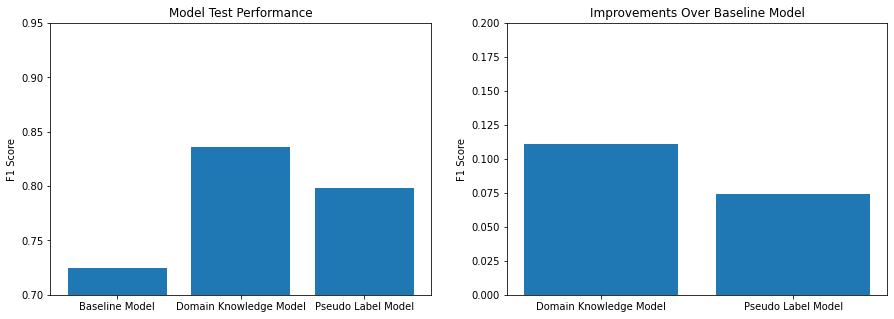


Model Performance 
Baseline Model: 0.725 
Domain Knowledge Model: 0.836 
Pseudo Label Model: 0.799

Improvments Over Baseline Model 
Domain Knowledge Model: 0.111 
Pseudo Label Model: 0.074


In [ ]:
results = [float(submissions_list[2].split(' ')[-8]), float(submissions_list_dk[2].split(' ')[-8]), float(submissions_list_pl[2].split(' ')[-8])]
diff = [results[1] - results[0], results[2] - results[0]]

fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax[0].bar(['Baseline Model', 'Domain Knowledge Model', 'Pseudo Label Model'], results)
ax[0].set_ylabel('F1 Score')
ax[0].set_title('Model Test Performance')
ax[0].set_ylim([0.7, 0.95])

ax[1].bar(['Domain Knowledge Model', 'Pseudo Label Model'], diff)
ax[1].set_ylabel('F1 Score')
ax[1].set_title('Improvements Over Baseline Model')
ax[1].set_ylim([0, 0.2])

plt.show()
print(f'\nModel Performance \nBaseline Model: {results[0]:.3f} \nDomain Knowledge Model: {results[1]:.3f} \nPseudo Label Model: {results[2]:.3f}')
print(f'\nImprovments Over Baseline Model \nDomain Knowledge Model: {diff[0]:.3f} \nPseudo Label Model: {diff[1]:.3f}')

<p align = 'justify'>The domain knowledge model and the pseudo label model both had better test performance than the baseline model, with improvements of <b><u>0.111</u></b> and <b><u>0.074</u></b> respectively. The results also show that for this dataset, <b><u>domain knowledge was able to outperform pseudo labelling</u></b>.</p>

<p align = 'justify'>Studies have shown that pseudo labelling is <b><u>prone to overfitting</b></u> and might not work for <b><u>certain distributions of data</b></u>. From our results, we can see the <b><u>importance of domain knowledge</b></u> in data science applications.</p>

# 7. Future Work <a name="7"></a>
<p align = 'justify'>In this notebook, I explored the use of pseudo labelling as the semi-supervised learning method and showed that it improves performance on the test set. To further improve the results, we could explore other semi-supervised methods such as <b><u>Consistency Regularization</b></u>, <b><u>Temporal Ensembling</b></u> and <b><u>Mean Teachers</b></u>.</p>

# 8. Conclusion <a name="8"></a>
<p align = 'justify'>In this work, I trained a <b><u>baseline model</b></u> to classify free text data obtained from omics repositories into 2 groups: control and perturbation and obtained F1 score of <b><u>72.5%</b></u>. I managed to improve the performance on the test dataset using <b><u>domain knowledge</b></u> and a semi-supervised method known as <b><u>pseudo labelling</b></u> by <b><u>11.1%</b></u> and <b><u>7.4%</b></u> respectively.</p>